In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, add
from tensorflow.keras import backend as K
from tensorflow.keras.layers import UpSampling2D, multiply
from tensorflow.keras.layers import Lambda

In [27]:
def UnetConv2D(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer="he_normal", padding="same", name=name + '_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer="he_normal", padding="same", name=name + '_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x
def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name=name + '_act')(x)
    return x
def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same', name='g_up' + name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3], name)
    y = multiply([upsample_psi, x], name='q_attn' + name)

    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
    result_bn = BatchNormalization(name='q_attn_bn' + name)(result)
    return result_bn
def expend_as(tensor, rep, name):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},
                       name='psi_up' + name)(tensor)
    return my_repeat

In [28]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [29]:
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp


def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn

In [30]:
kinit = 'he_normal'

In [31]:
def attn_unet(opt, input_size, lossfxn):
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2D(pool1, 32, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 64, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    center = UnetConv2D(pool4, 128, is_batchnorm=True, name='center')

    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu',
                                       kernel_initializer=kinit)(center), attn1], name='up1')

    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate(
        [Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=kinit)(up1),
         attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate(
        [Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=kinit)(up2),
         attn3], name='up3')

    up4 = concatenate(
        [Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=kinit)(up3),
         conv1], name='up4')
    out = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=kinit, name='final')(up4)

    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=opt, loss=lossfxn, metrics=[dsc, tp, tn])
    return model

In [32]:
model = attn_unet('adam', (256, 256, 1), 'binary_crossentropy')

In [33]:
model.load_weights('../model/model-T_u_a_d-maproad.h5')

In [34]:
from single_prediction import predict_image

1/1 [==============================] - 1s 511ms/step


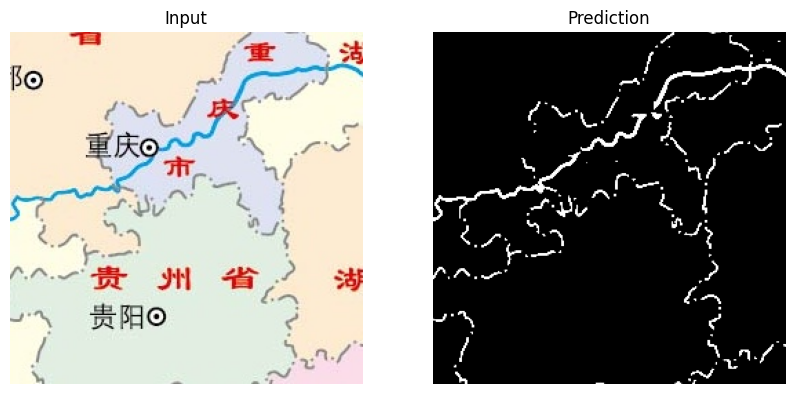

In [35]:
predict_image('../training_dataset/tianditu/images/0.jpg', model)